In [36]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations


%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score

normalize_to_max = lambda x:(x/np.nanmax(x))


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
matlab_data_dir = r'/home/kouroshmaboudi/Documents/NCMLproject/assemblyTuning_finalResults/'

rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (5, 12, 13)] # RatV sessions for now and Roy familiar sessions were excluded
current_sessions.append(5)

# current_sessions = [6]

number_of_sessions = len(current_sessions)

epoch_names = ['pre_nrem', 'pre_qw', 'pre_all_offline', 'pre_rem', 'maze_theta', 'maze', 'post_nrem', 'post_qw', 'post_all_offline', 'post_rem'] # combination of behavioral epoch and sleep/wake state
epoch_name_mapping = {'pre_nrem': 'SWS\nripples',
                      'pre_qw': 'QW\nripples',
                      'pre_all_offline': 'All offline',
                      'pre_rem': 'REM', 
                      'maze_theta': 'Theta',
                      'maze': 'QW\nripples',
                      'post_nrem': 'SWS\nripples',
                      'post_qw': 'QW\nripples',
                      'post_all_offline': 'All offline',
                      'post_rem': 'REM'
                      }


epoch_names2 = ['SWS\nripples', 'Quiet wake\nripples', 'All ripple','REM', 'Theta', 'Quiet wake\nripples', 'SWS\nripples', 'Quiet wake\nripples', 'All ripples ','REM']

num_units = np.empty((number_of_sessions,), dtype=int)
active_units = np.empty((number_of_sessions,), dtype=object)
stable_below_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE

learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

#-----------------------------------------------------------------------------------------------------
# Loading the NREM and QW learned tunings
# The LTs were recalculated for modified brain state detection

filename = f'learned_tunings_vs_posterior_gini_coeffs_NREM_QW.npy'
file_path = os.path.join('/home/kouroshmaboudi/Documents/Learned_tuning_Python', filename)

load_data = np.load(file_path, allow_pickle=True).item()
NREM_QW_learned_tunings = load_data['learned_tunings']


for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))


    session_dataset_path = os.path.join(main_dir, session_name)


    # Load epochs information
    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]



    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



    # Load unit stability information
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    
    spikes = [] # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        # unit_spikes['peak_firing_rate'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
                    # unit_spikes['peak_firing_rate'][direction] = spikes_pyr['peakFR'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        else: # Grosmark, Hiro, and all other sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


        #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Extract the cluster quality information by block for the current unit


        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']-1] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']-1][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        try:
            unit_spikes['pre_post_unit_stability'] = (
                # (unit_spikes['spike_amplitude_by_block'][0] > 0.8) & 
                (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
                (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
            ).all()
        except:
            unit_spikes['pre_post_unit_stability'] = np.nan 


        spikes.append(unit_spikes)


    # # load MAZE PF stability
    # maze_place_field_stabilities_curr_session = loadmat(os.path.join(session_dataset_path, session_name + '.PFstability.mat'))['PF_stability_across_blocks']


    """
    Learned tunings during different epochs
    """
    
    # Load .mat file
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))
    
    # active units
    # active_units[session_idx] = mat_file["activeUnits"]["post"].item().reshape([-1])
    # active_units[session_idx] = active_units[session_idx] - 1 # to account for python zero indexing
    # num_units[session_idx] = len(active_units[session_idx])

    # loading the learned tunings from differnet .mat sources
    learned_tunings_curr_session = dict()
    
    learned_tunings_curr_session['maze'] = mat_file["assemblyTunings"]['run'].item()['data'].item()
    learned_tunings_curr_session['pre_all_offline'] = mat_file["assemblyTunings"]['pre'].item()['data'].item()
    learned_tunings_curr_session['post_all_offline'] = mat_file["assemblyTunings"]['post'].item()['data'].item()
    

    #-------------------------------------------------------------------------------------------------------------
    # learned tunings based on separate QW and NREM ripples 

    # filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # learned_tunings_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

    # learned_tunings_curr_session['pre_nrem'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_NREM']
    # learned_tunings_curr_session['pre_qw'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_QW']

    # learned_tunings_curr_session['post_nrem'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_NREM']
    # learned_tunings_curr_session['post_qw'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_QW']


    for epoch in ['pre', 'post']:
        for ripple_category in ['nrem', 'qw']:
            learned_tunings_curr_session[f'{epoch}_{ripple_category}'] = NREM_QW_learned_tunings[session_idx][epoch][ripple_category.upper()]



    # # learned tunings for QW and NREM ripples and equalized number of firing bins for each units across epochs
    # filename = f'{session_name}.learned_tunings_NREM_vs_QW_matched_firing_PRE_and_POST.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # learned_tunings_matched_particpation = np.load(file_path, allow_pickle = True).item()

    # learned_tunings_curr_session['pre_nrem'] = learned_tunings_matched_particpation['pre']['NREM']
    # learned_tunings_curr_session['pre_qw'] = learned_tunings_matched_particpation['pre']['QW']
    # learned_tunings_curr_session['pre_all_offline'] = learned_tunings_matched_particpation['pre']['all_offline']

    # learned_tunings_curr_session['post_nrem'] = learned_tunings_matched_particpation['post']['NREM']
    # learned_tunings_curr_session['post_qw'] = learned_tunings_matched_particpation['post']['QW']
    # learned_tunings_curr_session['post_all_offline'] = learned_tunings_matched_particpation['post']['all_offline']



    # MAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_activeRun_binDur0.02.mat'))
    learned_tunings_curr_session['maze_theta'] = mat_file['learnedTunings']

    # MAZE theta learned tunings calculated from firings on peak or trough of theta 
    session_matlab_dataset_path = os.path.join(matlab_data_dir, session_name, 'assemblyTunings')


    filename = f'{session_name}.assemblyTunings_maze_theta_amp_phase_freq_ripple_channel_above_velocity_10cms-1.mat' #
    file_path = os.path.join(session_matlab_dataset_path, filename)
    mat_file = loadmat(file_path)

    theta_phase_learned_tunings = mat_file['learnedTunings_theta_phase']
    theta_phase_level_names = ['trough', 'ascend', 'peak', 'descend']
    for level in [0, 2]:
        learned_tunings_curr_session[f'theta_phase_{theta_phase_level_names[level]}'] = theta_phase_learned_tunings[:, :, level]



    # REM learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, 'NREM_REM_', session_name + '.assemblyTunings_REM_0.020.mat'))
    
    learned_tunings_curr_session['pre_rem'] = mat_file['assemblyTunings']['pre'].item()[0][0][0]
    learned_tunings_curr_session['post_rem'] = mat_file['assemblyTunings']['post'].item()[0][0][0]


    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit
        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']
          
          
    active_units[session_idx] = np.where((np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1) & (pre_post_unit_stability_curr_session == True))[0]
    num_units[session_idx] = len(active_units[session_idx])


    stable_below_1Hz_PF_unit_index[session_idx] = np.where((np.nanmax(spatial_tunings_maze[session_idx], axis=1) <= 1) & (pre_post_unit_stability_curr_session == True))[0]


    

    # spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units[session_idx]]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()
    num_shuffles = 10000

    epochs_theta_phase_names = list(learned_tunings_curr_session.keys())
    for epoch, epoch_name in enumerate(epochs_theta_phase_names): #epoch_names

        learned_tunings[session_idx][epoch_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):

            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][active_units[session_idx][unit]]

            if len(curr_unit_learned_tuning) != num_pos_bins_interp:
                curr_unit_learned_tuning = curr_unit_learned_tuning.reshape(num_pos_bins)
                curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            else:
                curr_unit_learned_tuning = curr_unit_learned_tuning.reshape(num_pos_bins_interp)
                
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # An additional smoothing of the learned tunings during the sleep epochs
            if epoch_name not in ['maze_theta']: # PRE, MAZE, POST, or latePOST
                curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')


            # Normalize
            learned_tunings[session_idx][epoch_name][unit] = curr_unit_learned_tuning
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            # learned_tunings[session_idx][epoch_name][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][epoch_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )
        
    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)


Achilles_10252013 1/15
Achilles_11012013 2/15
This session has only one running direction
Buddy_06272013 3/15
Cicero_09172014 4/15
Gatsby_08282013 5/15
This session has only one running direction
RatN_Day2_2019-10-11_03-58-54 6/15


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


RatS-Day2-2020-11-27_10-22-29 7/15
RatU_Day2NSD_2021-07-24_08-16-38 8/15
RatV_Day1NSD_2021-10-02_08-10-23 9/15
RatV_Day3NSD_2021-10-07_08-10-12 10/15
Roy-maze1 11/15
Ted-maze1 12/15
Ted-maze2 13/15
Ted-maze3 14/15
Kevin-maze1 15/15


In [16]:
num_left_over_cells = [np.where(x)[0].shape[0] for x in active_units]

print(num_left_over_cells)

print(np.sum(np.array(num_left_over_cells).reshape(3,-1), axis= 1))

[71, 76, 16, 20, 19, 46, 49, 130, 29, 49, 38, 23, 28, 18, 39]
[202 303 146]


### Concatenate across the sessions

In [37]:
# Concatenate place fields from all sessions and sort them according to the peak place field locations
spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)


# place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)
# place_field_stability_maze_concat = place_field_stability_maze_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(epochs_theta_phase_names)
learned_tunings_place_field_population_vector_correlation = dict.fromkeys(epochs_theta_phase_names)
for epoch, epoch_name in enumerate(epochs_theta_phase_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][epoch_name])
    learned_tunings_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)

    # population vector correlation between the learned tunings and the place fields

    all_zero_LT_unit_index = np.sum(learned_tunings_sessions_concat[epoch_name], axis=1) == 0
    # current_place_fields = spatial_tunings_maze_sessions_concat[~all_zero_LT_unit_index]
    # current_learned_tunings = learned_tunings_sessions_concat[epoch_name][~all_zero_LT_unit_index]

    # learned_tunings_place_field_population_vector_correlation[epoch_name] = calculate_all_column_correlations(current_place_fields, current_learned_tunings)


    current_place_fields = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze_sessions_concat)
    current_learned_tuning = np.apply_along_axis(normalize_to_max, 1, learned_tunings_sessions_concat[epoch_name])

    learned_tunings_place_field_population_vector_correlation[epoch_name] = calculate_all_column_correlations(current_place_fields[~all_zero_LT_unit_index], current_learned_tuning[~all_zero_LT_unit_index])


learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(epochs_theta_phase_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(epochs_theta_phase_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(epochs_theta_phase_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(epochs_theta_phase_names)

for epoch, epoch_name in enumerate(epochs_theta_phase_names):
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][epoch_name])
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)
    # learned_tunings_place_field_corr_sessions_concat[epoch_name] = learned_tunings_place_field_corr_sessions_concat[epoch_name][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name][place_fields_sort_idx]


    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[epoch_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[epoch_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[epoch_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[epoch_name])/num_shuffles


/tmp/ipykernel_106555/4060590237.py:44: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


### Plotting Learned Tunings and Population Vector Correlation Matrices
##### In this section, we plot the learned tunings and the population vector correlation matrices between the learned tunings and the place fields. The correlation matrices provide an estimate of how well the learned tunings align with the place fields. The cumulative distribution of the place fidelity of the learned tunings is also plotted.


/tmp/ipykernel_106555/4060590237.py:44: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))
/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


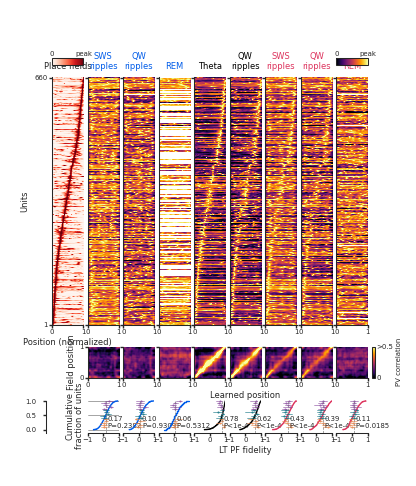

In [20]:
# epochs_to_plot = np.array([item for item in epochs_theta_phase_names if item not in ['pre_all_offline', 'post_all_offline', 'theta_phase_trough', 'theta_phase_peak']])
epochs_to_plot = np.array([item for item in epoch_names if item not in ['pre_all_offline', 'post_all_offline']])


colors = [
    '#005CE9', # PRE
    'black',# MAZE
    '#DD335D' # # POST
    ] 

dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 


def get_epoch_color(i):
    if i<= 2:
        color = colors[0]    
    elif i <=4:
        color = colors[1]
    else:
        color = colors[2]
    return color

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement
        

sns.set_style('whitegrid')
sns.set_context('paper')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':5,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})



# Create figure and subplots
plotheight = 350
plotwidth = 300
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=4, ncols=len(epochs_to_plot)+2, figure=fig, height_ratios=[0.02, 0.75, 0.15, 0.1], width_ratios=[1,1,1,1,1,1,1,1,1, 0.1], wspace = 0.15, hspace = 0.15)


c_map = 'inferno'


# plot MAZE place fields
ax0 = fig.add_subplot(gs[1, 0])

place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

current_data = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]
current_data = np.apply_along_axis(normalize_to_max, 1, current_data)

ax0.imshow(current_data, vmin=0, vmax=1, cmap='Reds', aspect='auto', interpolation='none', origin='lower')
ax0.set_xticks([0, 199])
ax0.set_xticklabels(['0', '1'])
ax0.set_yticks([0, spatial_tunings_maze_sessions_concat.shape[0] - 1])
ax0.set_yticklabels(['1', str(spatial_tunings_maze_sessions_concat.shape[0])])
ax0.set_ylabel('Units', fontsize = font_size)

ax0.set_xlabel('Position (normalized)', fontsize = font_size, labelpad=2)
ax0.set_title('Place fields', fontsize = font_size)
ax0.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)

# epochs_to_plot = np.array([item for item in epoch_names if item not in ['pre_nrem', 'pre_qw', 'post_nrem', 'post_qw']])

ax0_cbar = fig.add_subplot(gs[0, 0])
cbar = plt.colorbar(ax0.get_images()[0], cax = ax0_cbar, orientation = 'horizontal', drawedges = False)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')


# plot epoch's learned tunigs
for i, epoch in enumerate(epochs_to_plot):
    ax1 = fig.add_subplot(gs[1, i+1])

    current_data = learned_tunings_sessions_concat[epoch][place_fields_sort_idx]
    current_data = np.apply_along_axis(normalize_to_max, 1, current_data)

    ax1.imshow(current_data, vmin=0, vmax=1, cmap=c_map, aspect='auto', interpolation='none', origin='lower')
    ax1.set_xticks([0, 199])
    ax1.set_xticklabels(['0', '1'])
    ax1.set_yticks([0, spatial_tunings_maze_sessions_concat.shape[0] - 1], [])
    ax1.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
    ax1.set_title(epoch_name_mapping[epoch], color= get_epoch_color(i), fontsize = font_size)

ax1_cbar = fig.add_subplot(gs[0, i+1])
cbar = plt.colorbar(ax1.get_images()[0], cax = ax1_cbar, orientation = 'horizontal', drawedges = False)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')


# plot population vector correlations between position bins in learned tunings and place fields

max_correlation = 0.5
for i, epoch in enumerate(epochs_to_plot):
    ax2 = fig.add_subplot(gs[2, i+1])

    ax2.imshow(learned_tunings_place_field_population_vector_correlation[epoch], vmin=0, vmax=max_correlation, cmap=c_map, aspect='auto', interpolation='none', origin='lower') # np.amax(learned_tunings_place_field_population_vector_correlation[epoch])
    ax2.set_xticks([0, num_pos_bins_interp-1])
    ax2.set_xticklabels(['0', '1'])

    ax2.set_yticks([0, num_pos_bins_interp])
    if i == 0:
        ax2.set_yticklabels(['0', '1'])
    else:
        ax2.set_yticklabels([])
    
    if i==0:
        ax2.set_ylabel('Field position', fontsize = font_size, labelpad=2)

    if i==4:    
        ax2.set_xlabel('Learned position', fontsize = font_size, labelpad=2)

    ax2.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)
    ax2.set_aspect('equal')

ax2_cbar = fig.add_subplot(gs[2, i+2])
cbar = plt.colorbar(ax2.get_images()[0], cax = ax2_cbar, orientation = 'vertical', drawedges = False)
cbar.set_label("PV correlation", labelpad=2)
cbar.set_ticks([0, max_correlation])
cbar.set_ticklabels([0, f'>{max_correlation}'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_ticks_position('top')
ax2_cbar.set_aspect(20)


# plot the cumulative distributions of PF fidelities (of learned tunings)
for i, epoch in enumerate(epochs_to_plot):
    ax3 = fig.add_subplot(gs[3,i+1])
    ax3.set_facecolor((0, 0, 0, 0))  # Set the background to transparent

    sns.ecdfplot(learned_tunings_place_field_corr_sessions_concat[epoch], ax = ax3, label={epoch}, color=get_epoch_color(i), linewidth = 1)
    ax3.set_xlim([-1,1])
    
    if i > 0:
        ax3.set_yticks([])

    if i==4:
        ax3.set_xlabel('LT PF fidelity', fontsize=font_size, labelpad=2)
    if i==0:
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['left'].set_position(('outward', 30))
        ax3.set_ylabel('Cumulative\nfraction of units', fontsize = font_size, labelpad=2)

    else:
        ax3.set_ylabel('')
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['left'].set_visible(False)

    ax3.tick_params(axis='both', which='major', labelsize=5, length=2, width=1, pad=1)

    
    ax3.yaxis.set_label_coords(-0.1, 0.5)  # Move the y-axis label to the left a bit
    ax3.spines['left'].set_bounds(-0.1, 1.0)  # Set the bounds of the y-axis spine
    
    # Move the y-axis labels and ticks up a bit
    for tick in ax3.yaxis.get_major_ticks():
        tick.set_pad(5)
    
    ax3.set_ylim(bottom=-0.1)

    # adding medians and their p-values
    ax3.axvline(lt_pf_correlation_median_across_all_sessions[epoch], color='gray', linestyle='dashed', linewidth=0.5)
    xpos = lt_pf_correlation_median_across_all_sessions[epoch]+0.1
    ypos = 0.05
    ax3.text(xpos, ypos, "{:.2f}\n{}".format(lt_pf_correlation_median_across_all_sessions[epoch], get_pval_statement(lt_pf_correlation_median_across_all_sessions_pvalue[epoch])), fontsize=5)
    ax3.set_ylim([-0.1,1.05])
    if i == 0:
        ax3.set_yticks([0, 0.5, 1])
    else:
        ax3.set_yticks([])
    ax3.grid(axis='y', color='gray', linewidth=0.5)


    # Add the median and IQR for each session
    ylim = ax3.get_ylim()
    for session_idx in range(number_of_sessions):
        session_number = current_sessions[session_idx]
        session_name = rr[session_number]

        if session_number in range(5):
            color = dataset_specific_colors[0]
        elif session_number in range(6,11):
            color = dataset_specific_colors[1]
        else:
            color = dataset_specific_colors[2]

        current_session_data = learned_tunings_place_field_corr[session_idx][epoch]

        # ax1.scatter(np.nanmedian(current_session_data), 0.6*ylim[1]+ np.random.normal(0, 0.2*ylim[1], 1), s= 0.5, color=color, alpha=0.8) 
        
        current_session_y = 0.1*ylim[1]+0.06*session_idx*ylim[1]
        ax3.plot([np.nanpercentile(current_session_data, 25), np.nanpercentile(current_session_data, 75)], [current_session_y]*2, linewidth=0.5, color=color, alpha=0.8)
        ax3.scatter(np.nanmedian(current_session_data),  current_session_y, s= 0.25, color=color, alpha=0.8) 


plt.show()

filename = 'Figure2_NREM_QW_separate.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


### Correlation between NREM and QW learned tunings

In [24]:

# population vector correlation between the NREM and QW learned tunings for PRE and POST

learned_tunings_nrem_qw_population_vector_correlation = dict()
for epoch in ['pre', 'post']:

    current_nrem_data = learned_tunings_sessions_concat[f'{epoch}_nrem']
    current_nrem_data = np.apply_along_axis(normalize_to_max, 1, current_nrem_data)

    current_qw_data = learned_tunings_sessions_concat[f'{epoch}_qw']
    current_qw_data = np.apply_along_axis(normalize_to_max, 1, current_qw_data)

    learned_tunings_nrem_qw_population_vector_correlation[epoch] = calculate_all_column_correlations(current_nrem_data, current_qw_data)

/tmp/ipykernel_106555/4060590237.py:44: RuntimeWarning: invalid value encountered in divide
  normalize_to_max = lambda x:(x/np.nanmax(x))


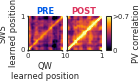

In [18]:
#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':6,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # POST
    ] 

plotheight = 60
plotwidth = 100
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=3, figure=fig, hspace=0.3, wspace=0.2, width_ratios=[1,1,0.15])

max_correlation = 0.7

for epoch_idx , epoch_name in enumerate(['pre', 'post']):
    ax0 = fig.add_subplot(gs[epoch_idx])

    ax0.imshow(learned_tunings_nrem_qw_population_vector_correlation[epoch_name], vmin=0, vmax=max_correlation, interpolation='none', cmap=c_map, origin='lower', aspect='auto')

    ax0.set_xticks([0, num_pos_bins_interp], [0, 1])
    if epoch_idx == 0:
        ax0.set_xlabel('QW\nlearned position', fontsize = font_size, labelpad=2)

    ax0.set_yticks([0, num_pos_bins_interp])

    if epoch_idx == 0:
        ax0.set_ylabel('SWS\nlearned position', fontsize = font_size, labelpad=2)
        ax0.set_yticklabels([0, 1])
    else:
        ax0.set_ylabel('')
        ax0.set_yticklabels([])

    ax0.set_title(epoch_name.upper(), fontsize = font_size, fontweight='bold', pad=2, color = colors[epoch_idx])

    ax0.tick_params(axis='both', which='major', labelsize=5, length=1, width=1, pad=1)

ax_cbar = fig.add_subplot(gs[0,2])
cbar = plt.colorbar(ax0.get_images()[0], cax=ax_cbar, orientation='vertical', drawedges= False)
cbar.set_label("PV correlation", labelpad=2)
cbar.set_ticks([0, max_correlation])
cbar.set_ticklabels([0, f'>{max_correlation}'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_label_position('bottom')


plt.subplots_adjust(left=0.2, right= 0.8, bottom=0.4, top=0.8)

filename = 'QW_NREM_correaltion.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

### Correlation between the LT fidelity versus place field peak location


/tmp/ipykernel_30488/945901100.py:100: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
/tmp/ipykernel_30488/945901100.py:330: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


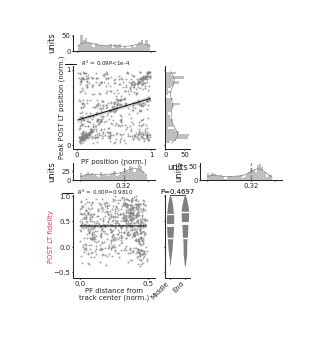

In [24]:
from scipy.stats import stats
import pandas as pd
from scipy.stats import mannwhitneyu


# defining functions
def plot_violin(ax, data, color):
    alpha = 1
    sns.violinplot(data=data, x = 'PF_in_track_end', y = 'LT_fidelity',  ax=ax, color=color, inner='quartiles', width=0.5, linewidth=0, cut=0)
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 2):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(2)
        l.set_color('white')
        l.set_alpha(1)
    # # ax.grid(axis='y', color='gray', linewidth=1)
    # for axis in ['left', 'bottom']:
    #     ax.spines[axis].set_linewidth(1.5)

def get_pval_statement(pvalue):

    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement



# set plot style and context

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)


# set plot size nnd create a plot
plotheight = 250
plotwidth = 240
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=4, ncols=4, figure=fig, width_ratios=[1, 0.3, 1, 0.3], height_ratios = [0.2, 1, 0.2, 1], hspace=0.3, wspace=0.2)


#-----------------------------------------------------------------------------------------------------------
#  POST LT fidelity versus PF distance from track end

# Data
x = place_fields_peak_locations
x = x / 200
# x = [np.min([peak_location, 1-peak_location]) for peak_location in x]
x = [np.abs(peak_location-0.5) for peak_location in x]
x = np.array(x)

y = learned_tunings_place_field_corr_sessions_concat['post_all_offline']

# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept



# Marginal distribution of PF distance from the track end

ax_0 = fig.add_subplot(gs[2, 0])
rr = sns.histplot(x=x, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax_0)
ax_0.set_xlim([-0.05, 0.55])
ax_0.set_xlabel("")
ax_0.set_ylabel("units")
ax_0.tick_params(axis='both', which='major', length=1, pad=1, width=1)
# plot the median line
current_median = np.nanmedian(x)
ax_0.axvline(x = current_median, linestyle='--', color = 'gray', linewidth=1)
ax_0.set_xticks([0, current_median, 0.5])
ax_0.set_xticklabels(['', f'{current_median:.2f}', ''])




# Create the scatterplot
ax0 = fig.add_subplot(gs[3,0])

sns.scatterplot(
    x=x,
    y=y,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=2, 
    alpha=0.7, 
    ax=ax0, 
    )

# Add the best-fit line
sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.9},
            ax=ax0)


ax0.set_xlim([-0.05, 0.55])
ax0.set_ylim([-0.6, 1.02])

ax0.set_xticks([0, 0.5])

ax0.set_xlabel("PF distance from\ntrack center (norm.)", fontsize=font_size, labelpad=1)
ax0.set_ylabel("POST LT fidelity", fontsize=font_size, color='#DC335D', labelpad=0)

ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax0.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))



# Violinplot by catgorizing the units into units with PF in track end or middle

ax1 = fig.add_subplot(gs[3,1])
df = pd.DataFrame({'LT_fidelity':y, 'PF_in_track_end':x > (1/3)}) # True: Track end, False: Track middle

plot_violin(ax1, df, (.5, .5, .5))

# ax1.set_xlabel('PF peak location', fontsize=font_size, labelpad=0)
ax1.set_ylabel('')
# ax1.set_ylabel('POST LT fidelity', fontsize=font_size, color='#DC335D', labelpad=0)
# ax1.set_xticklabels(['Middle', 'End'])

ax1.set_ylim([-0.6, 1.02])
ax1.set_yticklabels([])


ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Middle', 'End'], rotation=45, ha='right')
ax1.set_xlabel('')

ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)


_, p_value = mannwhitneyu(y[x > (1/3)], y[x <= 1/3])

significance_line_y = ax1.get_ylim()[1]

ax1.plot([0,1], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
[ax1.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [0, 1]]

ax1.annotate(get_pval_statement(p_value), xy = (0.5, significance_line_y), color = 'black', ha = "center", va="bottom", fontsize = 5)





#-----------------------------------------------------------------------------------------------------------
#  POST LT fidelity versus its peak distance from track end

# Data

peak_locations_post_LTs = np.argmax(learned_tunings_sessions_concat['post_all_offline'], axis=1)


x = peak_locations_post_LTs
x = x / 200
# x = [np.min([peak_location, 1-peak_location]) for peak_location in x]
x = [np.abs(peak_location-0.5) for peak_location in x]
x = np.array(x)

# y = learned_tunings_place_field_corr_sessions_concat['post_all_offline']


# # Remove NaN values
# valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
# x = x[valid_index]
# y = y[valid_index]

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# line = slope * x + intercept



# Marginal distribution of POST LT peak distance

ax_0 = fig.add_subplot(gs[2, 2])
rr = sns.histplot(x=x, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax_0)
ax_0.set_xlim([-0.05, 0.55])
ax_0.set_xlabel("")
ax_0.set_ylabel("units")
ax_0.tick_params(axis='both', which='major', length=1, pad=1, width=1)
# plot the median line
current_median = np.nanmedian(x)
ax_0.axvline(x = current_median, linestyle='--', color = 'gray', linewidth=1)
ax_0.set_xticks([0, current_median, 0.5])
ax_0.set_xticklabels(['', f'{current_median:.2f}', ''])


# # Create the scatterplot
# ax0 = fig.add_subplot(gs[3,2])

# sns.scatterplot(
#     x=x,
#     y=y,
#     color = 'gray',
#     marker='o',
#     edgecolor = 'black',
#     linewidth=0, 
#     s=2, 
#     alpha=0.7, 
#     ax=ax0, 
#     )

# # Add the best-fit line
# sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
#             label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
#             line_kws={"linewidth":0.75, "alpha":0.9},
#             ax=ax0)


# ax0.set_xlim([-0.05, 0.55])
# ax0.set_ylim([-0.6, 1.02])
# ax0.set_yticklabels([])

# ax0.set_xticks([0, 0.5])

# ax0.set_xlabel("Peak POST LT distance from\ntrack center (norm.)", fontsize=font_size, labelpad=1)
# # ax0.set_ylabel("POST LT fidelity", fontsize=font_size, color='#DC335D', labelpad=0)

# ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

# ax0.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))



# # Violinplot by catgorizing the units into units with PF in track end or middle

# ax1 = fig.add_subplot(gs[3,3])
# df = pd.DataFrame({'LT_fidelity':y, 'PF_in_track_end':x > (1/3)}) # True: Track end, False: Track middle

# plot_violin(ax1, df, (.5, .5, .5))

# # ax1.set_xlabel('PF peak location', fontsize=font_size, labelpad=0)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# # ax1.set_ylabel('POST LT fidelity', fontsize=font_size, color='#DC335D', labelpad=0)
# # ax1.set_xticklabels(['Middle', 'End'])

# ax1.set_ylim([-0.6, 1.02])

# ax1.set_xticks([0, 1])
# ax1.set_xticklabels(['Middle', 'End'], rotation=45, ha='right')
# ax1.set_yticklabels([])


# ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)


# _, p_value = mannwhitneyu(y[x > (1/3)], y[x <= 1/3])

# significance_line_y = ax1.get_ylim()[1]

# ax1.plot([0,1], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
# [ax1.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [0, 1]]

# ax1.annotate(get_pval_statement(p_value, '*'), xy = (0.5, significance_line_y), color = 'black', ha = "center", va="bottom", fontsize = 5)




#----------------------------------------------------------------------------------------------------------------------------
# plot peak PF versus peak post LT


x = place_fields_peak_locations
x = x / 200
# x = [np.abs(peak_location-0.5) for peak_location in x]
x = np.array(x)


y = peak_locations_post_LTs
y = y / 200
# y = [np.abs(peak_location-0.5) for peak_location in y]
y = np.array(y)

# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept


# plot the marginal distributions

# PF 
ax_0 = fig.add_subplot(gs[0, 0])
rr = sns.histplot(x=x, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax_0)
ax_0.set_xlim([-0.05, 1.05])
ax_0.set_xticks([0, 1])
ax_0.set_xlabel("")
ax_0.set_ylabel("units")
ax_0.set_xticklabels([])
ax_0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

# POST LT peaks
ax_1 = fig.add_subplot(gs[1, 1])
rr = sns.histplot(y = y, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, orientation="vertical", ax = ax_1)
ax_1.set_ylim([-0.05, 1.05])
ax_1.set_ylabel("")
ax_1.set_yticks([0, 1])
ax_1.set_xlabel("units")
ax_1.set_yticklabels([])
ax_1.tick_params(axis='both', which='major', length=1, pad=1, width=1)




# Create the scatterplot
ax0 = fig.add_subplot(gs[1,0])

sns.scatterplot(
    x=x,
    y=y,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=2, 
    alpha=0.7, 
    ax=ax0, 
    )

# Add the best-fit line
sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":.9},
            ax=ax0)


ax0.set_xlim([-0.05, 1.05])
ax0.set_ylim([-0.05, 1.05])

ax0.set_xticks([0, 1])
ax0.set_yticks([0, 1])

ax0.set_xlabel("PF position (norm.)", fontsize=font_size, labelpad=1)
ax0.set_ylabel("Peak POST LT position (norm.)", fontsize=font_size, labelpad=1)

ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax0.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))



# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.90)


filename = 'LT_fidelity_versus_PF_location.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()


### LT fidelity/stability versus unit firing properties

In [152]:
def p_score(arr):
    percentile_scores = []
    n = len(arr)
    for i in range(n):
        current_element = arr[i]
        count = np.sum(current_element > arr)  # Count elements greater than current_element
        percentile = (count / n) * 100  # Calculate the percentile score
        percentile_scores.append(percentile)

    return percentile_scores


filename = 'unitProperties_firingRate_burstiness_distnaceFromTrackEnd_etc.mat'
file_path = os.path.join(main_dir, filename)

mat_file = loadmat(file_path)
unit_properties_matlab = mat_file['unit_properties']

unit_property_names_from_matlab = ['PF_stability',
                       ##'PF_peak_FR', 
                       'spatial_info', 
                       ##'PF_distance_from_middle_of_track', 
                       'burstiness', 
                       'POST_firing_rate', 
                       'POST_FR_coefficient_of_variation',
                       'POST_LT_stability',
                    #    'POST_LT_fidelity'
                       ]


unit_properties = np.empty((number_of_sessions,), dtype=object)
# unit_properties_percentile_scores = np.empty((number_of_sessions,), dtype=object)
for session_idx in range(number_of_sessions):
    current_session_units = active_units[session_idx]

    unit_properties[session_idx] = dict.fromkeys(unit_property_names_from_matlab, [])
    # unit_properties_percentile_scores[session_idx] = dict.fromkeys(unit_property_names_from_matlab, [])

    for unit_property_name in unit_property_names_from_matlab: 
        unit_properties[session_idx][unit_property_name] = unit_properties_matlab[unit_property_name][0][0][session_idx][0][current_session_units].reshape(current_session_units.shape[0])
        # unit_properties_percentile_scores[session_idx][unit_property_name] = p_score(unit_properties[session_idx][unit_property_name])


unit_properties_pooled = dict.fromkeys(unit_property_names_from_matlab, [])
# unit_properties_percentile_scores_pooled =  dict.fromkeys(unit_property_names_from_matlab, [])
for unit_property_name in unit_property_names_from_matlab:
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(unit_properties[session_idx][unit_property_name])
    unit_properties_pooled[unit_property_name] = np.concatenate(temp , axis = 0)

    # temp = []
    # for session_idx in range(number_of_sessions):
    #     temp.append(unit_properties_percentile_scores[session_idx][unit_property_name])
    # unit_properties_percentile_scores_pooled[unit_property_name] = np.concatenate(temp , axis = 0)



In [168]:
import pandas as pd

# Generate a dataframe for analysis of LT fidelity/stability as functions of unit firing properties
unit_properties_df = pd.DataFrame(unit_properties_pooled)

# Add parameters that I calculated here to the data frame:
# PF location in respect tp the middle of the track
place_fields_peak_locations_norm = place_fields_peak_locations/200
unit_properties_df['PF_distance_from_middle_of_track'] = [np.abs(peak_location-0.5) for peak_location in place_fields_peak_locations_norm]

# peak PF firing rate 
unit_properties_df['PF_peak_FR'] = np.nanmax(spatial_tunings_maze_sessions_concat, axis=1)

# post LT fidelity
unit_properties_df['POST_LT_fidelity'] = learned_tunings_place_field_corr_sessions_concat['post_all_offline']

# Session number
unit_properties_df['session_number']  = each_unit_session_number_sessions_concat

# Update the unit property names based on what we just add to the dataframe, excluding session_number, LT fidelity and stability
# unit_property_names = unit_properties_df.columns.tolist()
# unit_property_names = np.setdiff1d(unit_property_names, ['POST_LT_fidelity', 'POST_LT_stability', 'session_number'])
unit_property_names = [
    'PF_peak_FR',
    'PF_stability',
    'spatial_info',                    
    'PF_distance_from_middle_of_track', 
    'burstiness', 
    'POST_firing_rate' 
]

# Add the session percentiles for each unit property as seperate columns
df_unique_session_numbers = unit_properties_df['session_number'].unique()
for sn in df_unique_session_numbers:
    current_session_units =  np.where(unit_properties_df['session_number'] == sn)[0]

    for unit_property in np.setdiff1d(unit_property_names, ['PF_distance_from_middle_of_track']):
        unit_properties_df.loc[current_session_units, f'{unit_property}_as_session_percentile'] = p_score(unit_properties_df.loc[current_session_units, unit_property].values) 
    
    


In [ ]:
from matplotlib import ticker
from scipy.stats import ranksums

# ---------------------------------------------------------------------------------------------------------
# Define functions
# Define a function to plot violin plots

# Define a function to plot violin plots
def plot_violin(ax, data, yvar, color): #, color
    alpha = 0.8
    order = ['low', 'high']
    vio = sns.violinplot(data=data, x='unit_prop_low_or_high', y =yvar, order=order, bw=0.15, color = color, split=True, cut=0, inner='quartiles', ax=ax, linewidth=0, capstyle='butt', width = 0.5) #  palette=color,
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 6):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color='gray', linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")
    

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

def categorize(value, threshold):

    # to categorize as low if below median and high if above median
    if value >= threshold:
        return 'high'
    else:
        return 'low'


def remove_trailing_zeros(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

# def get_pval_statement(pvalue, sign):
#     if pvalue < 0.0001:
#         pvalue_statement = sign*2    
#     elif pvalue < 0.01:
#         pvalue_statement = sign
#     else:
#         pvalue_statement = 'ns'
#     return pvalue_statement

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':3,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':1
})


#-------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
plotheight = 150
plotwidth = 300
font_size = 6

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 
def get_epoch_color(i):
    if i<= 2:
        color = colors[0]    
    elif i <=4:
        color = colors[1]
    else:
        color = colors[2]
    return color


dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 


fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=len(unit_property_names), height_ratios = [0.67, 1, 1], wspace = 0.3, hspace=0.5, figure=fig) #, height_ratios=[1, 1]


# Comparing the distributions of learned tunings corresponding to units in subcategories based on cetrain properties of the units, e.g.
# PF stability, peak PF firing rate, location of the track, etc

for unit_property_index, unit_property_name in enumerate(unit_property_names):

    # Plot the distribution of unit firing property for pooled data and for individual sessions
    ax0 = fig.add_subplot(gs[0, unit_property_index])
    current_values = unit_properties_df[unit_property_name].values
    sns.histplot(current_values, bins=30, cumulative=False, stat='probability', kde=True, color=(.4,.4,.4), edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0)
    ax0.set_ylabel("")

    ax0.axvline(x=np.nanmedian(current_values), color=(.4,.4,.4), linestyle = '--', linewidth=1)
    yl = ax0.get_ylim()
    ax0.text(np.nanmedian(current_values), yl[1], f'{np.nanmedian(current_values):.2f}', ha='center', fontsize=4)

    ylim_old = ax0.get_ylim()
    ax0.set_ylim([0, ylim_old[1]])

    ylim = ax0.get_ylim()
    for session_idx in range(number_of_sessions):
        session_number = current_sessions[session_idx]
        if session_number in range(5):
            color = dataset_specific_colors[0]
        elif session_number in range(6,11):
            color = dataset_specific_colors[1]
        else:
            color = dataset_specific_colors[2]

        current_session_data = unit_properties_df.loc[unit_properties_df['session_number'] == session_number, unit_property_name].values
        
        current_session_y = 0.2*ylim[1]+0.05*session_idx*ylim[1]
        ax0.plot([np.nanpercentile(current_session_data, 25), np.nanpercentile(current_session_data, 75)], [current_session_y]*2, linewidth=0.5, color=color, alpha=0.7)
        ax0.scatter(np.nanmedian(current_session_data),  current_session_y, s= 0.25, color=color, alpha=0.8) 

    if unit_property_name not in ['PF_distance_from_middle_of_track', 'PF_stability']:
        ax0.set_xlim([0, np.nanpercentile(current_values, 99)])
    else:
        ax0.set_xlim([0, np.nanpercentile(current_values, 100)])

    ax0.set_xlabel(unit_property_name, fontsize=3, labelpad = 1)
    ax0.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)

    ax0.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
    ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))  

    # plot the LT stabilities and fidelities
    if unit_property_name == 'PF_distance_from_middle_of_track':
        current_df = unit_properties_df[[unit_property_name, 'POST_LT_stability', 'POST_LT_fidelity', 'session_number']]
        aa = current_df[unit_property_name].apply(lambda x: categorize(x, 0.33))
        current_df.loc[:, 'unit_prop_low_or_high'] = aa.copy()
    else:
        print(unit_property_name)
        current_df = unit_properties_df[[f'{unit_property_name}_as_session_percentile', 'POST_LT_stability', 'POST_LT_fidelity', 'session_number']]
        aa = current_df[f'{unit_property_name}_as_session_percentile'].apply(lambda x: categorize(x, 50))
        current_df.loc[:, 'unit_prop_low_or_high'] = aa.copy()

    for lt_property_index, lt_property in enumerate(['POST_LT_stability', 'POST_LT_fidelity']):

        ax1 = fig.add_subplot(gs[lt_property_index+1, unit_property_index])

        plot_violin(ax1, current_df, lt_property, (0.5, 0.5, 0.5))
        
        # The medians of individual sessions
        for session_idx in range(number_of_sessions):
            session_number = current_sessions[session_idx]
            if session_number in range(5):
                color = dataset_specific_colors[0]
            elif session_number in range(6,11):
                color = dataset_specific_colors[1]
            else:
                color = dataset_specific_colors[2]

            current_session_lt_property_values = [np.nan]*2

            for unit_property_level_index, unit_property_level in enumerate(['low', 'high']):
                idx = (current_df['session_number'] == session_number) & (current_df['unit_prop_low_or_high'] == unit_property_level)
                current_session_lt_property_values[unit_property_level_index] = np.nanmedian(current_df.loc[idx, lt_property])

            ax1.plot([0.2, 0.8], current_session_lt_property_values, linewidth= 0.5, color=color, alpha=0.6) 

        # Perform ranksum test to compare between the violins
        x1 = current_df.loc[current_df['unit_prop_low_or_high'] == 'low', lt_property].values
        x2 = current_df.loc[current_df['unit_prop_low_or_high'] == 'high', lt_property].values
        _, p_value = ranksums(x1, x2, nan_policy = 'omit')


        ax1.axhline(y=0.95*ax1.get_ylim()[1], xmin = 0.2, xmax = 0.8, color = 'black', linewidth=0.5)
        ax1.annotate(get_pval_statement(p_value), xy = (np.mean(ax1.get_xlim()), 0.9*ax1.get_ylim()[1]), xytext = (np.mean(ax1.get_xlim()), 0.5), color = 'gray', ha = "center", va="bottom", fontsize = 4)


        ax1.set_xlabel('')
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

        if lt_property == 'POST_LT_fidelity':
            ax1.set_ylim([-0.5, 1])
            ax1.set_yticks(np.linspace(-0.5, 1, 4))


        if unit_property_index == 0:
            ax1.set_ylabel(lt_property.replace("_", " "), labelpad=1)
        else:
            ax1.set_ylabel('')
            ax1.set_yticklabels([])

        ax1.tick_params(axis='both', which='major', labelsize=5, length=2, pad=1)


plt.show()

filename = 'learned_tunings_vs_unit_firing_properties.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


### Figure 6: POST fidelity versus PRE fidelity

In [ ]:
from scipy.stats import stats
import matplotlib.ticker as ticker

# Define functions
def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label

def get_pval_statement(pvalue, sign):
    if pvalue < 0.0001:
        pvalue_statement = sign*2    
    elif pvalue < 0.01:
        pvalue_statement = sign
    else:
        pvalue_statement = 'ns'
    return pvalue_statement



# set plot style and context

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)


# set plot size nnd create a plot
plotheight = 90
plotwidth = 300
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=3, figure=fig, hspace=0.3, wspace=0.3)


#------------------------------------------------------------------------------------
# POST versus PRE LT fidelity scatter plot

ax0 = fig.add_subplot(gs[0])

# format the data
x = learned_tunings_place_field_corr_sessions_concat['pre_all_offline']
y = learned_tunings_place_field_corr_sessions_concat['post_all_offline']

# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]


sns.scatterplot(
    x=x,
    y=y,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=2, 
    alpha=0.7, 
    ax=ax0, 
    )

# Add the best-fit line

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
            line_kws={"linewidth":0.75, "alpha":0.8},
            ax=ax0)


ax0.set_xlim([-1, 1])
ax0.set_ylim([-1, 1])

ax0.set_xticks(np.arange(-1,1.01,0.5))
ax0.set_yticks(np.arange(-1,1.01,0.5))

ax0.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


ax0.set_xlabel("PRE LT fidelity", fontsize=font_size, color = '#005CE9', labelpad=1)
ax0.set_ylabel("POST LT fidelity", fontsize=font_size, color='#DC335D', labelpad=0)

ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax0.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))


#------------------------------------------------------------------------------------
# Sleep similarity versus PRE fidelity 

ax1 = fig.add_subplot(gs[1])

num_shuffles = 5
sleep_similarity, _, _ = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_sessions_concat['pre_all_offline'], learned_tunings_sessions_concat['post_all_offline'], num_shuffles)

x = learned_tunings_place_field_corr_sessions_concat['pre_all_offline']
y = sleep_similarity



# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]


sns.scatterplot(
    x=x,
    y=y,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=2, 
    alpha=0.7, 
    ax=ax1, 
    )

# Add the best-fit line

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
            line_kws={"linewidth":0.75, "alpha":0.8},
            ax=ax1)


ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])

ax1.set_xticks(np.arange(-1,1.01,0.5))
ax1.set_yticks(np.arange(-1,1.01,0.5))

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


ax1.set_xlabel("PRE LT fidelity", fontsize=font_size, color = '#005CE9', labelpad=1)
ax1.set_ylabel("Sleep similarity", fontsize=font_size, labelpad=0)

ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax1.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))


#------------------------------------------------------------------------------------
# POST fidelity versus sleep similarity

ax2 = fig.add_subplot(gs[2])

x = sleep_similarity
y = learned_tunings_place_field_corr_sessions_concat['post_all_offline']


# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]


sns.scatterplot(
    x=x,
    y=y,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=2, 
    alpha=0.7, 
    ax=ax2, 
    )

# Add the best-fit line

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
            line_kws={"linewidth":0.75, "alpha":0.8},
            ax=ax2)


ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])

ax2.set_xticks(np.arange(-1,1.01,0.5))
ax2.set_yticks(np.arange(-1,1.01,0.5))

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


ax2.set_xlabel("Sleep similarity", fontsize=font_size, labelpad=0)
ax2.set_ylabel("POST LT fidelity", fontsize=font_size, color = '#DC335D', labelpad=1)

ax2.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax2.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))


# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.90)

filename = 'POST_fidelity_vs_PRE_fidelity.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()


/tmp/ipykernel_106555/1616949869.py:115: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
/tmp/ipykernel_106555/1616949869.py:144: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value_significant_tuned, p_value_significant_tuned, std_err = stats.linregress(xx[zz < 5], yy[zz < 5])
/tmp/ipykernel_106555/1616949869.py:207: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)


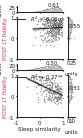

In [27]:

# Define functions
def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label

def get_pval_statement(pvalue, sign):
    if pvalue < 0.0001:
        pvalue_statement = sign*2    
    elif pvalue < 0.01:
        pvalue_statement = sign
    else:
        pvalue_statement = 'ns'
    return pvalue_statement


# set plot style and context

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':4,
    'axes.titlesize':8,
    'xtick.labelsize':4,
    'ytick.labelsize':4,
    'legend.fontsize':4,
    'legend.title_fontsize':4,
    'legend.frameon': False,
    'legend.markerscale':1,
    'xtick.major.size':1,
    'ytick.major.size':1
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)
    

# format the data
x = sleep_similarity
y = learned_tunings_place_field_corr_sessions_concat['post_all_offline']

temp = learned_tunings_place_field_corr_unit_id_shuffle_concat['pre_all_offline'] > np.tile(learned_tunings_place_field_corr_sessions_concat['pre_all_offline'], (10000, 1)).T
pre_lt_pf_percentile_scores_indiv_units = np.sum(temp , axis=1)/10000 * 100
z = pre_lt_pf_percentile_scores_indiv_units


# Remove NaN values
valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
x = x[valid_index]
y = y[valid_index]
z = z[valid_index]


# set plot size nnd create a plot
plotheight = 100
plotwidth = 60
font_size = 4

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=4, ncols=2, height_ratios=[0.15,1,0.15,1], width_ratios = [1, 0.15], figure=fig, hspace=0.2, wspace=0.2)

#------------------------------------------------------------------------------------
# PRE-tuned units

ax0 = fig.add_subplot(gs[1,0])

pre_tuned_index = z < 50
xx = x[pre_tuned_index]
yy = y[pre_tuned_index]
zz = z[pre_tuned_index]

sns.scatterplot(
    x=xx[zz > 5],
    y=yy[zz > 5],
    color = (.5,.5,.5),
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=1, 
    alpha=0.7, 
    ax=ax0, 
    )

sns.scatterplot(
    x=xx[zz < 5],
    y=yy[zz < 5],
    color = 'white',
    marker='o',
    edgecolor = 'black',
    linewidth=0.25, 
    s=1, 
    alpha=0.7, 
    ax=ax0, 
    )


# Add the best-fit line

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
line = slope * xx + intercept

sns.regplot(x=xx, y=yy, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
            line_kws={"linewidth":0.75, "alpha":0.8},
            ax=ax0)


ax0.set_xlim([-1, 1])
ax0.set_ylim([-1, 1])

ax0.set_xticks(np.arange(-1,1.01,1))
ax0.set_xticklabels("")

ax0.set_yticks(np.arange(-1,1.01,1))

# ax0.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


ax0.set_ylabel("POST LT fidelity", fontsize=font_size, color='#DC335D', labelpad=0)

ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax0.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.2))


# Calculate R^2 for only significantly pre-tuned cells 
slope, intercept, r_value_significant_tuned, p_value_significant_tuned, std_err = stats.linregress(xx[zz < 5], yy[zz < 5])



# Marginal distributions of sleep similarity and POST PF fidelity for PRE_tuned units

# Sleep similarity

ax0_1 = fig.add_subplot(gs[0, 0])
sns.histplot(xx, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0_1)
ax0_1.set_xlim([-1,1])
ax0_1.set_xlabel("")
ax0_1.set_ylabel("units")
ax0_1.set_xticklabels([])
ax0_1.tick_params(axis='both', which='major', length=1, pad=0, width=1)


current_median = np.nanmedian(xx)
ax0_1.axvline(x=current_median, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)
yl = ax0_1.get_ylim()
ax0_1.text(current_median, yl[1], f'{current_median:.2f}', ha='center', fontsize=4)

# POST fidelity
ax0_2 = fig.add_subplot(gs[1,1])
sns.histplot(y= yy, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0_2)

ax0_2.set_ylim([-1, 1])
ax0_2.set_ylabel("")
ax0_2.set_xlabel("units")
ax0_2.set_yticklabels([])
ax0_2.tick_params(axis='both', which='major', length=1, pad=0, width=1)

current_median = np.nanmedian(yy)
ax0_2.axhline(y=0, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)
xl = ax0_2.get_xlim()
ax0_2.text(xl[1], current_median, f'{current_median:0.2f}', ha='center', fontsize=4)


#------------------------------------------------------------------------------------
# PRE-untuned units

ax1 = fig.add_subplot(gs[3,0])

pre_untuned_index = z > 50
xx = x[pre_untuned_index]
yy = y[pre_untuned_index]

sns.scatterplot(
    x=xx,
    y=yy,
    color = 'gray',
    marker='o',
    edgecolor = 'black',
    linewidth=0, 
    s=1, 
    alpha=0.7, 
    ax=ax1, 
    )


# Add the best-fit line

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
line = slope * xx + intercept

sns.regplot(x=xx, y=yy, ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value, "*")}',
            line_kws={"linewidth":0.75, "alpha":0.8},
            ax=ax1)


ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])

ax1.set_xticks(np.arange(-1,1.01,1))
ax1.set_yticks(np.arange(-1,1.01,1))

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

ax1.set_xlabel("Sleep similarity", fontsize=font_size, labelpad=1)
ax1.set_ylabel("POST LT fidelity", fontsize=font_size, color='#DC335D', labelpad=0)

ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax1.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.2))



# Marginal distributions of sleep similarity and POST PF fidelity for PRE_tuned units

# Sleep similarity

ax1_1 = fig.add_subplot(gs[2, 0])
sns.histplot(xx, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax1_1)
ax1_1.set_xlim([-1,1])
ax1_1.set_xlabel("")
ax1_1.set_ylabel("units")
ax1_1.set_xticklabels([])
ax1_1.tick_params(axis='both', which='major', length=1, pad=0, width=1)


current_median = np.nanmedian(xx)
ax1_1.axvline(x=current_median, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)
yl = ax1_1.get_ylim()
ax1_1.text(current_median, yl[1], f'{current_median:.2f}', ha='center', fontsize=4)

# POST fidelity
ax1_2 = fig.add_subplot(gs[3,1])
sns.histplot(y= yy, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax1_2)

ax1_2.set_ylim([-1, 1])
ax1_2.set_ylabel("")
ax1_2.set_xlabel("units")
ax1_2.set_yticklabels([])
ax1_2.tick_params(axis='both', which='major', length=1, pad=0, width=1)

current_median = np.nanmedian(yy)
ax1_2.axhline(y=0, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)
xl = ax1_2.get_xlim()
ax1_2.text(xl[1], current_median, f'{current_median:0.2f}', ha='center', fontsize=4)


# Adjust the plot layout
plt.subplots_adjust(left=0.2, right= 0.90, bottom=0.15, top=0.95)

filename = 'PRE_tuned_vs_untuned_units_POSTfidelity_vs_sleep_similarity_Figure6___.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()

In [35]:
print(r_value_significant_tuned)
print(p_value_significant_tuned)
np.where(z < 5)[0].shape

0.49851422061828615
0.00042194355996815847


(46,)

### POST learned tunings predictions by MAZE PFs, PRE and MAZE learned tunings and PFs
Regressing POST LTs against PRE LTs and MAZE PFs, ripple LTs and theta LTs 

In [38]:
from sklearn.linear_model import LinearRegression

r2_loo = np.full((number_of_sessions+1,), np.nan)
p_r2_loo = np.full((number_of_sessions+1,), np.nan)
coeffs_loo = [[] for _ in range(number_of_sessions+1)]
p_coeffs_loo = [[] for _ in range(number_of_sessions+1)]
intercept_loo = np.full((number_of_sessions+1,), np.nan)

if ~np.isin(999, current_sessions):
    current_sessions.append(999) # 999 is not among the sessions, but adding it enables us to calculate the pooled result without exclluding any of the actual sessions

for excluded_session_idx, excluded_session in enumerate(current_sessions):

    print(excluded_session_idx)
    
    included_sessions = np.setdiff1d(current_sessions, excluded_session)
    
    unit_subset = np.where(np.isin(each_unit_session_number_sessions_concat, included_sessions))[0]

    DV = learned_tunings_sessions_concat['post_all_offline'][unit_subset] # dependent variable 
    DV = np.apply_along_axis(z_score, 1, DV)
    
    average_Y  = np.nanmean(np.concatenate([np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['pre_all_offline'][unit_subset]),
                                            np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['post_all_offline'][unit_subset])], axis = 0), axis = 0)
    average_Y  = (average_Y - np.nanmean(average_Y))/np.nanstd(average_Y)
    background = np.tile(average_Y, [DV.size // average_Y.size, 1])

    predictors       = np.concatenate(
        (background.flatten()[:, np.newaxis],
        np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['pre_all_offline'][unit_subset]).flatten()[:, np.newaxis], 
        np.apply_along_axis(z_score, 1, spatial_tunings_maze_sessions_concat[unit_subset]).flatten()[:, np.newaxis], 
        np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['maze_theta'][unit_subset]).flatten()[:, np.newaxis], 
        # np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['theta_phase_trough'][unit_subset]).flatten()[:, np.newaxis],
        # np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['theta_phase_peak'][unit_subset]).flatten()[:, np.newaxis],
        np.apply_along_axis(z_score, 1, learned_tunings_sessions_concat['maze'][unit_subset]).flatten()[:, np.newaxis], 
        ),
        axis=1)
        

    predictor_labels = [ 
        'average LT', 
        'PRE LTs',
        'MAZE PFs',
        'MAZE theta LTs',
        # 'MAZE theta trough',
        # 'MAZE theta peak',
        'MAZE ripple LTs',    
        ] # add 'intercept' to the labels for plotting


    num_predictors = len(predictor_labels)


    non_nan_idx = np.where(~np.isnan(DV.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

    lm     = LinearRegression().fit(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
    r2_loo[excluded_session_idx] = lm.score(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
    coeffs_loo[excluded_session_idx] = lm.coef_
    intercept_loo[excluded_session_idx] = lm.intercept_


    # comapring the R^2 and regression coefficients to shuffles
    num_shuffles = 10000

    r2_shuffle     = np.zeros(num_shuffles)
    coeffs_shuffle = np.zeros((num_predictors, num_shuffles))

    for shuffle_idx in range(num_shuffles):
        DV_randomized = DV[np.random.permutation(DV.shape[0]), :] # randomizing the units indices in the dependent variable (e.g., REMAZE place fields)

        non_nan_idx = np.where(~np.isnan(DV_randomized.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

        shuffle_lm    = LinearRegression().fit(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
        r2_shuffle[shuffle_idx]        = shuffle_lm.score(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
        coeffs_shuffle[:, shuffle_idx] = shuffle_lm.coef_

    p_r2_loo[excluded_session_idx]     = (r2_loo[excluded_session_idx] < r2_shuffle).sum() / num_shuffles
    p_coeffs_loo[excluded_session_idx] = (coeffs_loo[excluded_session_idx].reshape(-1, 1) < coeffs_shuffle).sum(axis=1) / num_shuffles



0


/tmp/ipykernel_106555/4060590237.py:42: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score


1


/tmp/ipykernel_106555/4060590237.py:42: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score


2


/tmp/ipykernel_106555/4060590237.py:42: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score


3


/tmp/ipykernel_106555/4060590237.py:42: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


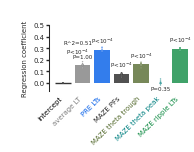

In [255]:
def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<$10^{-4}$'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    return pvalue_statement


#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':6,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 

plotheight = 110
plotwidth = 140#125
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)


colors = [
    'black', # intercept
    [.5,.5,.5], # background
    '#005CE8', # PRE learned tunings
    [0.1490, 0.1490,  0.1490], # MAZE place fields
    [0.2039, 0.3843, 0.1882], # MAZE theta learned tunings
    # [0.3333, 0.4196, 0.1843], # MAZE theta trough learned tunings
    # [0.0, 0.5019, 0.5019], # MAZE theta peak learned tunings
    [0.0627, 0.5451, 0.2667], # MAZE ripple learned tunings
    ]

ax = fig.add_subplot(gs[0])

h = ax.bar(np.arange(num_predictors+1), np.concatenate([[intercept_loo[-1]], coeffs_loo[-1]]), align='center', alpha=0.8, linewidth=0, color=colors)
for ih in range(1):
    h[ih].set_facecolor('none')
    h[ih].set_edgecolor('black')
    h[ih].set_linewidth(1)

for exluded_session_index, excluded_session in enumerate(current_sessions[:-1]):
    ax.scatter(np.arange(num_predictors+1), np.concatenate([[intercept_loo[exluded_session_index]], coeffs_loo[exluded_session_index]]), s = 0.5, alpha=0.9, linewidth=0.25, facecolors = 'white', edgecolor=colors)


for ih in range(3,num_predictors+1):
    h[ih].set_edgecolor('none')

for ip in range(0, num_predictors):
    ax.text(ip+1, coeffs_loo[-1][ip]+0.06*np.sign(coeffs_loo[-1][ip]), get_pval_statement(p_coeffs_loo[-1][ip]), horizontalalignment='center', fontsize = 4)

ax.text(0.75, 0.3, 'R^2={:.2f}\n{}'.format(r2_loo[-1], get_pval_statement(p_r2_loo[-1])), horizontalalignment='center', verticalalignment='center', fontsize = 4)

ax.set_xticks(np.arange(num_predictors+1))
# ax.set_xticks([])
ax.set_xticklabels(np.concatenate([['intercept'], predictor_labels]), fontsize=font_size, ha='right', va='top')
ax.tick_params(axis = 'x', rotation=45)
ax.tick_params(axis = 'both')
for i , label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])


# ax.set_ylabel('reMAZE place fields\nregression coeffs', fontsize=font_size)
ax.set_ylabel('Regression coefficient', fontsize=font_size)
ax.set_ylim([-0.07, 0.50])

ax.set_yticks([0, .1, .2, .3, 0.4, 0.5])
# ax.yaxis.grid(True)

# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

ax.tick_params(axis='both', which='major', length=2, pad=1, width=1)

ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)


plt.subplots_adjust(left=0.25, right= 1, bottom=0.4, top=0.83)


filename = 'multiple_regression_POST_LTs_theta_trough_and_peak.pdf'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, dpi=300)

plt.show()

